In [1]:
'''
Energy model to compare with measurement
Unit: mm
Author: Yitian Shao
Created on 2021.01.15
'''
%matplotlib notebook 
%matplotlib notebook 

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

from PouchLib import getEpsilon0 

EPSILON0 = getEpsilon0() # (Farad/m) Free-space permittivity

shellThickness = 0.020 # (mm) Denoted as 'l_s' in publication
epsilon_s = 2.0 # Relative permittivity of the shell
epsilon_f = 3.2 # Relative permittivity of the fluid

c shared library imported successfully!


In [2]:
'''
General Functions
'''

def aPlot(figName, is3D = False):
    ax = []
    
    fig1 = plt.figure(figsize = (10,4))
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

''' Additional Computation for the whole pouch based on pouch structure'''
def addComputation(DFdata, pouchStructure):
    rectNum = np.sum(pouchStructure +1) # Number of rectangle pouch-cell <- np.sum(pouchStructure - 1)
    triNum = rectNum*2 - len(pouchStructure) -3 # Number of triangle pouch-cell <- rectNum*2 - len(pouchStructure) +1
    print("Pouch contains totally %d rectangle and %d triangle" % (rectNum, triNum))

    DFdata['totalVol'] = (triNum * DFdata['triVol'] + rectNum * DFdata['rectVol']) # (mm3) Total volume of the entire pouch
    DFdata['totalLength'] = (DFdata['dashSpace'] + DFdata['dashLength']) * len(pouchStructure) - DFdata['dashSpace'] # (mm) Total length of the entire pouch
    DFdata['totalWidth'] = DFdata['dashHalfDist'] * 2 * (np.amax(pouchStructure) + 1) # (mm) Total width of the entire pouch

    DFdata['triArea'] = DFdata['dashSpace'] * DFdata['dashHalfDist'] # (mm2) Top-view area of a triangle pouch (Not surface area)
    DFdata['rectArea'] = 2 * DFdata['dashHalfDist'] * DFdata['dashLength'] # (mm2) Top-view area of a rectangle pouch (Not surface area)

    DFdata['totalCapa'] = (triNum * DFdata['triCapa'] + rectNum * DFdata['rectCapa']) # (Farad)
    
    return DFdata, rectNum, triNum
    

In [3]:
''' Additional Computation for the whole pouch based on pouch structure'''
pouchStructure = np.array([6, 5, 4, 3, 2, 1])

DATA_PATH = "./data/PouchModelData.csv"
data = pd.read_csv(DATA_PATH)
print("Data contains %d rows and %d columns" % data.shape)

data, rectNum, triNum = addComputation(data, pouchStructure)

data.head(1)

Data contains 900 rows and 11 columns
Pouch contains totally 27 rectangle and 45 triangle


,dashHalfDist,dashSpace,R,triArc,triFA,triPSA,triVol,rectVol,triCapa,rectCapa,dashLength,totalVol,totalLength,totalWidth,triArea,rectArea,totalCapa
0,4.7,12.66,9.896901,10.000197,9.378996,18.042664,139.582626,112.54795,4.101019e-13,2.687822e-12,12.0,9320.012845,135.3,65.8,59.502,112.8,9.102578e-11


In [5]:
''' Partially zipped with fluid trapped in cells '''
diameterFullyExpanded = data['triArc'].iloc[0] * 2 / np.pi
print("Cell fully expanded with fluid has a diameter = %.3f mm" % diameterFullyExpanded)

data['oneCellExpand'] = data['triArc'] * (np.amax(pouchStructure)) + diameterFullyExpanded

data.head()
data.to_csv("ToCompareLength.csv")

Cell fully expanded with fluid has a diameter = 6.366 mm


<IPython.core.display.Javascript object>


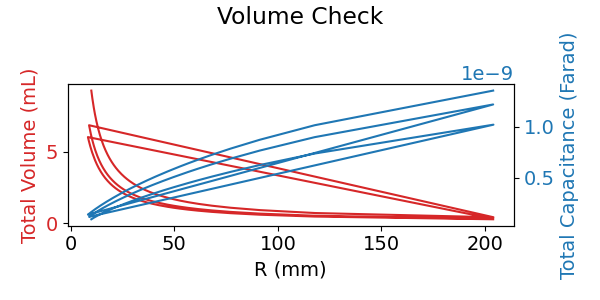

In [7]:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(6,3)
fig1.suptitle("Volume Check")
ax1.set_xlabel('R (mm)')

ax1.plot(data['R'], data['totalVol']/1000, color='tab:red')
ax1.set_ylabel('Total Volume (mL)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx() 
ax2.plot(data['R'], data['totalCapa'], color='tab:blue')
ax2.set_ylabel('Total Capacitance (Farad)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig1.tight_layout() 


In [9]:
selectCondition = 'dashSpace==8.66'
twoState = pd.concat((data.query(selectCondition).iloc[[0]], data.query(selectCondition).iloc[[-1]]), axis=0) 
twoState.head()

,dashHalfDist,dashSpace,R,triArc,triFA,triPSA,triVol,rectVol,triCapa,rectCapa,dashLength,totalVol,totalLength,totalWidth,triArea,rectArea,totalCapa
300,4.700,8.66,8.806314,9.999598,9.374053,10.22604,62.954919,149.984840,4.120522e-13,3.585402e-12,16.0,6882.562049,147.96,65.800,40.70200,150.400,1.153482e-10
599,4.999,8.66,204.000222,9.999001,0.408366,0.40847,2.652689,6.533852,6.837825e-12,3.383006e-11,16.0,295.785017,147.96,69.986,43.29134,159.968,1.221114e-09


In [11]:
''' Zipped state '''
zippedTriCapa = twoState['triArea'].iloc[0] * 1e-6 * EPSILON0 * epsilon_s / (2 * shellThickness * 1e-3)
zippedRectCapa = twoState['rectArea'].iloc[0]  * 1e-6 * EPSILON0 * epsilon_s / (2 * shellThickness * 1e-3)
print("Capacitance of fully zipped triangle cell is %f and rectangle cell is %f Picofarad" % (zippedTriCapa*1e12, zippedRectCapa*1e12))

Capacitance of fully zipped triangle cell is 18.019158 and rectangle cell is 66.583492 Picofarad


In [23]:
Wps = 1 # (Joule) Work done by power supply
U = 6900 # (V) Driven voltage

deltaTriCapa = zippedTriCapa - twoState['triCapa'].iloc[0] # Fully zipped capacitance
deltaRectCapa = zippedRectCapa - twoState['rectCapa'].iloc[0] # Fully zipped capacitance
# deltaTriCapa = twoState['triCapa'].iloc[1] - twoState['triCapa'].iloc[0]
# deltaRectCapa = twoState['rectCapa'].iloc[1] - twoState['rectCapa'].iloc[0]

deltaC = triNum * deltaTriCapa+ rectNum * deltaRectCapa # (Farad) Increased capacitance

deltaEs = 0.5 * U*U * deltaC
print("Change of electrostatic potential energy (Joule) = ", deltaEs)

deltaV = (twoState['totalVol'].iloc[0]) * 1e-9 # (m3) Decreased volume of fluid <- twoState['totalVol'].iloc[1]
print("Change of fluid volume (m3) = ", deltaV)

######### avgP = (Wps - deltaEs)/deltaV # This is inaccurate since power disspation is large before supplied to the actuator
avgP = deltaEs/deltaV # (2*deltaEs-deltaEs)
print("Average pressure P = %f kPa" % (avgP*1e-3))

''' Partially zipped (reality) '''
oneExpandTriNum = 2*(len(pouchStructure)-1)
oneExpandRectNum = len(pouchStructure)
partZipTriNum = triNum - oneExpandTriNum
partZipRectNum = rectNum - oneExpandRectNum
print("Partially zipped pouch (one expand per column) contains totally %d rectangle and %d triangle" % (partZipRectNum, partZipTriNum))

deltaC2 = partZipTriNum * deltaTriCapa+ partZipRectNum * deltaRectCapa # (Farad) Increased capacitance when not fully zipped
deltaEs2 = 0.5 * U*U * deltaC2
print("(Not fully zipped) Change of electrostatic potential energy (Joule) = ", deltaEs2)

oneExpandRectVol = (data['triArc'].iloc[0] * data['triArc'].iloc[0] / np.pi) * data['dashLength'].iloc[0] # Unit: mm3
#deltaV2 = deltaV - (oneExpandTriNum*twoState['triVol'].iloc[0] + oneExpandRectNum*twoState['rectVol'].iloc[0]) * 1e-9 # Unit: m3
deltaV2 = deltaV - (oneExpandTriNum*twoState['triVol'].iloc[0] + oneExpandRectNum*oneExpandRectVol) * 1e-9 # Unit: m3
print("(Not fully zipped) Change of fluid volume (m3) = ", deltaV2)

avgP2 = deltaEs2/deltaV2 # (2*deltaEs-deltaEs)
print("(Not fully zipped) Average pressure P = %f kPa" % (avgP2*1e-3))

Change of electrostatic potential energy (Joule) =  0.05935224915022073
Change of fluid volume (m3) =  6.882562049264529e-06
Average pressure P = 8.623569 kPa
Partially zipped pouch (one expand per column) contains totally 21 rectangle and 35 triangle
(Not fully zipped) Change of electrostatic potential energy (Joule) =  0.04616286045017168
(Not fully zipped) Change of fluid volume (m3) =  3.961091333779248e-06
(Not fully zipped) Average pressure P = 11.654076 kPa
